In [ ]:
# Imports
from datasets import load_dataset
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import os, json
from transformers import pipeline
import torch
from torchmetrics.text.rouge import ROUGEScore
from torch.utils.data import Subset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset

In [ ]:
dataset = load_dataset("generative-newsai/news-unmasked")

In [ ]:
train_set = dataset["train"]
test_set = dataset["test"]

# Visualizing the data

In [ ]:
train_set.__len__(), test_set.__len__()

In [ ]:
train_set.features, test_set.features

In [ ]:
train_set[0]

In [ ]:
test_set[random.choice(range(test_set.__len__()))]

In [ ]:
# how many test headlines have [MASK] in them?
mask_token = "[MASK]"
test_with_mask = [x for x in test_set["headline"] if mask_token in x]
print(f"{len(test_with_mask)} out of {len(test_set)} test headlines have [MASK] in them")

In [ ]:
# get tests without [MASK] in them
test_without_mask = [x for x in test_set["headline"] if mask_token not in x]
print(f"{len(test_without_mask)} out of {len(test_set)} test headlines do not have [MASK] in them")

Headlines with no mask in test set

In [ ]:
test_without_mask[random.choice(range(len(test_without_mask)))]

In [ ]:
sections = np.unique(test_set["section"])
print("Unique sections in the test dataset: ", len(sections))

Observations: We have image, section and a masked headline. We need to predict the appropriate word for the masked headline.

In [ ]:
# how many train headlines have [MASK] in them?
train_with_mask = [x for x in train_set["headline"] if mask_token in x]
print(f"{len(train_with_mask)} out of {len(train_set)} train headlines have [MASK] in them")

In [ ]:
sections = np.unique(train_set["section"])
print("Unique sections in the train dataset: ", len(sections))

Observations: Not all the test entries have [MASK] token in them and there are 24 unique sections in the dataset.

## Plot section count

In [ ]:
# Plot np unique with counts
z_train = np.unique(train_set["section"], return_counts=True)
z_test = np.unique(test_set["section"], return_counts=True)

# np unique returns sorted unique elements
assert np.array_equal(z_train[0], z_test[0])

# plot grouped bar chart
fig, ax = plt.subplots()
x = np.arange(len(z_train[0]))
width = 0.35
rects1 = ax.bar(x - width / 2, z_train[1], width, label="Train")
rects2 = ax.bar(x + width / 2, z_test[1]*(train_set.__len__()/test_set.__len__()), width, 
                label="Scaled Up Test")
ax.set_ylabel("Count")
ax.set_title("Count by Section")
ax.set_xticks(x)
ax.set_xticklabels(z_train[0])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=90)
plt.show()

Observations: We have 24 unique sections with Well, Education, Global Business, Your Money, Economy and Automobiles having lowest occurence. Train dataset and test dataset follow similar pattern for section distribution

## Plot headline length by section

In [ ]:
# Group headline_length_per_section by section
from itertools import groupby

def groupby_section(dataset):
    ln_per_section = list(zip(dataset["section"], [len(headline) for headline in dataset["headline"]]))
    ln_per_section = sorted(ln_per_section, key=lambda x: x[0])
    ln_per_section = [(key, list(group)) for key, group in groupby(ln_per_section, lambda x: x[0])]
    ln_per_section = [(key, [x[1] for x in group]) for key, group in ln_per_section]
    ln_stats_per_section = [(key, np.mean(group), np.std(group)) for key, group in ln_per_section]
    return ln_stats_per_section

train_ln_stats_per_section = groupby_section(train_set)
test_ln_stats_per_section = groupby_section(test_set)

In [ ]:
# Plot train_ln_stats_per_section and test_ln_stats_per_section as grouped bar chart with error bars
fig, ax = plt.subplots()
x = np.arange(len(train_ln_stats_per_section))
width = 0.35
rects1 = ax.bar(x - width / 2, [x[1] for x in train_ln_stats_per_section], width, 
                yerr=[x[2] for x in train_ln_stats_per_section], label="Train")
rects2 = ax.bar(x + width / 2, [x[1] for x in test_ln_stats_per_section], width, 
                yerr=[x[2] for x in test_ln_stats_per_section], label="Test")
ax.set_ylabel("Headline Length")
ax.set_title("Headline Length by Section")
ax.set_xticks(x)
ax.set_xticklabels([x[0] for x in train_ln_stats_per_section])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=90)
plt.show()


Observations: No outliers in headline length. We can see that the length of the headline is similar across all sections and lies between ~30 to ~80 characters.

## Sample images

Uncomment to visualize

In [ ]:
imgs = []
for i, section in enumerate(tqdm(sections)):
    indices = random.choices(np.where(np.asarray(train_set["section"]) == section)[0], k=5)
    imgs.append(train_set[indices]["image"])

In [ ]:
# Plot images for each section
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i][random.randint(0, 4)])
    ax.set_title(sections[i])
    ax.axis("off")
plt.subplots_adjust(wspace=0)
plt.show()

In [ ]:
[img.size for img in train_set[random.sample(range(train_set.__len__()), 10)]["image"]]

Observations: Visualized Images have nytimes labeel showing what year it was printed, and sizes vary across images

# Deberta-Base-Uncased

Based on the sample notebook provided --> https://huggingface.co/datasets/generative-newsai/news-unmasked/blob/main/.extras/helper_notebook.ipynb

In [ ]:
model_name = "mlcorelib/deberta-base-uncased"
unmasker = pipeline('fill-mask', model=model_name)

## Check first 5 rows of the Test dataset

In [ ]:
# Check first 5 rows of the test dataset
sample_data = test_set[:5]
for k, v in sample_data.items():
    print("-"*50)
    print(k)
    print(*v, sep="\n")

## Unmask the sentences

In [ ]:
all_masked_words = []
test_subset = Subset(test_set, range(100))
for each_dict in tqdm(test_subset):
    sentence = each_dict['headline']  # Get the sentence from the dictionary
    image_id = each_dict['image_id']  # Get the image_id from the dictionary
    if "[MASK]" in sentence: # See if it has a [MASK] in headline
        result = unmasker(sentence)  # Unmask the sentence

        # Make a list of indices where [MASK] is present in the sentence
        # If there are more than one [MASK] in the sentence, then add them as separate entries in the result list
        indices = [i for i, x in enumerate(sentence.split()) if x == "[MASK]"]
        if len(indices) > 1:
            masked_word_idx_list = []
            for i, each_result in enumerate(result):
                # Get the top scoring word
                top_word = each_result[0]['token_str']
                all_masked_words.append([image_id, indices[i], top_word])
        else:
            all_masked_words.append([image_id, indices[0], result[0]['token_str']])

final_masked_words = [l[0] for l in all_masked_words]

## Print first 5 rows of the masked words list

In [ ]:
print(final_masked_words[:5])

## Save the results as a dataframe and print first 5 rows of the dataframe

In [ ]:
# Save the results in a dataframe with column name id,token_index,token
df = pd.DataFrame(all_masked_words, columns=['id', 'token_index', 'token'])
df.head()

## Save the dataframe as a csv file

In [ ]:
df.to_csv('sample_result.csv', index=False)

# Vision Language Models

## Idea: Caption the image
Ask LLM caption + mask sentence. Predict masks

In [ ]:
# divide train_set in train and validation
train_train_set, train_val_set = torch.utils.data.random_split(train_set, 
                                                               [int(0.8 * len(train_set)),
                                                                len(train_set) - int(0.8 * len(train_set))])

In [ ]:
len(train_train_set), len(train_val_set), len(train_set)

### Image Captioning using hf pipelines

#### VIT-GPT2-COCO

In [ ]:
from transformers import pipeline
from torchmetrics.text.rouge import ROUGEScore

device_id = 0 if torch.cuda.is_available() else -1

captioner = pipeline("image-to-text",model="ydshieh/vit-gpt2-coco-en", device=device_id)
captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png")
## [{'generated_text': 'two birds are standing next to each other '}]

In [ ]:
# Try captioner on one of the images in the validation set
rouge = ROUGEScore(use_stemmer=True)
sample = train_val_set[random.randint(0, len(train_val_set))]

caption = captioner(sample["image"], max_new_tokens=25)
rouge_score = rouge(caption[0]['generated_text'], sample["headline"])
plt.imshow(sample["image"])
print("generated_text: " + caption[0]['generated_text'], 
      "section: " + sample["section"],  
      "headline: " + sample["headline"], 
      "rouge1_fmeasure: " + str(rouge_score['rouge1_fmeasure']),
      "rouge2_fmeasure: " + str(rouge_score['rouge2_fmeasure']),
      "rougeL_fmeasure: " + str(rouge_score['rougeL_fmeasure']),
      "rougeLsum_fmeasure: " + str(rouge_score['rougeLsum_fmeasure']),
      sep="\n")

In [ ]:
# rouge1_fmeasure across validation subset
rouge1_fmeasure = []
train_val_subset = Subset(train_val_set, range(100))
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    rouge_score = rouge(caption[0]['generated_text'], data["headline"])
    rouge1_fmeasure.append(rouge_score['rouge1_fmeasure'])

In [ ]:
np.mean(rouge1_fmeasure), np.std(rouge1_fmeasure)

#### BLIP image captioning large

In [ ]:
captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-large", device=device_id)
captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png")
## VIT-GPT2 output: ## [{'generated_text': 'two birds are standing next to each other '}]
## BLIP output: [{'generated_text': 'there are two parrots that are standing next to each other'}]
## Observations: BLIP output seems more detailed

In [ ]:
# Try captioner on one of the images in the validation set
rouge = ROUGEScore(use_stemmer=True)
sample = train_val_set[random.randint(0, len(train_val_set))]

caption = captioner(sample["image"], max_new_tokens=25)
rouge_score = rouge(caption[0]['generated_text'], sample["headline"])
plt.imshow(sample["image"])
print("generated_text: " + caption[0]['generated_text'], 
      "section: " + sample["section"],  
      "headline: " + sample["headline"], 
      "rouge1_fmeasure: " + str(rouge_score['rouge1_fmeasure']),
      "rouge2_fmeasure: " + str(rouge_score['rouge2_fmeasure']),
      "rougeL_fmeasure: " + str(rouge_score['rougeL_fmeasure']),
      "rougeLsum_fmeasure: " + str(rouge_score['rougeLsum_fmeasure']),
      sep="\n")

In [ ]:
# rouge1_fmeasure across validation subset
rouge1_fmeasure = []
train_val_subset = Subset(train_val_set, range(100))
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    rouge_score = rouge(caption[0]['generated_text'], data["headline"])
    rouge1_fmeasure.append(rouge_score['rouge1_fmeasure'])

In [ ]:
np.mean(rouge1_fmeasure), np.std(rouge1_fmeasure)

# VIT-GPT2 scores: (0.06309018, 0.07374029)
# BLIP scores: (0.06341785, 0.069144554)

Observations:

Inference takes longer than VIT-GPT2 (4:47 as compared to 1:09 for inital 100 samples). Eye balling the results, BLIP image captioning large seems to be more specific to the image. VIT-GPT2 seems to be more generic. rouge score is slightly better for BLIP image captioning large for the first 100 samples. Std dev is also lower for BLIP image captioning large.

Conclusions:

Can try both models and see which gives better results for masked word prediction.

### Fill-Mask Pipeline

In [ ]:
from transformers import pipeline

unmasker = pipeline("fill-mask", model="distilroberta-base", device=device_id)
unmasker("Paris is the <mask> of France.")

# [{'score': 0.7, 'sequence': 'Paris is the capital of France.'},
# {'score': 0.2, 'sequence': 'Paris is the birthplace of France.'},
# {'score': 0.1, 'sequence': 'Paris is the heart of France.'}]

In [ ]:
sample = train_val_set[random.randint(0, len(train_val_set))]

# replace random word with <mask>
masked_sample = sample["headline"].split()
rand_index = random.randint(0, len(masked_sample)-1)
print(f"rand index: {rand_index}, len of headline: {len(masked_sample)}")

masked_sample[rand_index] = "<mask>"
masked_sample = " ".join(masked_sample)
sample["headline"], masked_sample

In [ ]:
unmasked = unmasker(masked_sample)

# compute rouge score with original headline
rouge = ROUGEScore(use_stemmer=True)
print("original headline: " + sample["headline"], "section: " + sample["section"], sep="\n")
for i in range(len(unmasked)):
    rouge_score = rouge(unmasked[i]['sequence'], sample["headline"])
    print("generated_text: " + unmasked[i]['sequence'],  
          "rouge1_fmeasure: " + str(rouge_score['rouge1_fmeasure']),
          "rouge2_fmeasure: " + str(rouge_score['rouge2_fmeasure']),
          "rougeL_fmeasure: " + str(rouge_score['rougeL_fmeasure']),
          "rougeLsum_fmeasure: " + str(rouge_score['rougeLsum_fmeasure']),
          sep="\n")

### Fill mask pipeline with caption as prompt

In [158]:
def randomMask(input, mask_token="[MASK]"):
    masked_input = input.split()
    rand_index = random.randint(0, len(masked_input)-1)
    masked_input[rand_index] = mask_token
    masked_input = " ".join(masked_input)
    return masked_input

original headline: Clive Barnes Award Winner and Nominees Are Announced
section: Dance
caption: dancers in red dresses are performing on a stage with a black background
masked_sample: [MASK] Barnes Award Winner and Nominees Are Announced
unmasked: the barnes award winner and nominees are announced
prompted_unmasked: . barnes award winner and nominees are announced


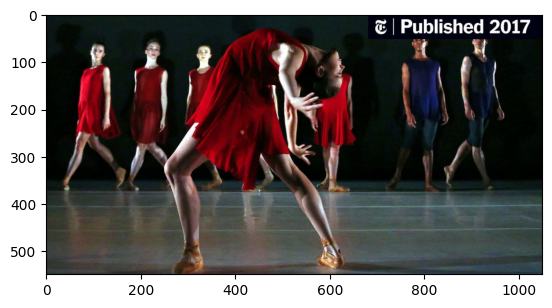

In [160]:
sample = train_val_set[random.randint(0, len(train_val_set))]
masked_sample = randomMask(sample["headline"])
sample["headline"], masked_sample

PADDING = "[ pad ]"
caption = captioner(sample["image"], max_new_tokens=25)
unmasked = unmasker(masked_sample)
prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)

plt.imshow(sample["image"])
print("original headline: " + sample["headline"], "section: " + sample["section"], sep="\n")
print("caption: " + caption[0]['generated_text'], "masked_sample: " + masked_sample, 
      "unmasked: " + unmasked[0]['sequence'], 
      "prompted_unmasked: " + prompted_unmasked[0]['sequence'].split(PADDING)[1],
        sep="\n")

In [162]:
# What percentage improves with prompting?

train_val_subset = Subset(train_val_set, range(10))
rouge1_fmeasure_prompted = []
rouge1_fmeasure_unprompted = []
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    
    masked_sample = randomMask(data["headline"])
    
    unmasked = unmasker(masked_sample)
    prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
    rouge1_fmeasure_prompted.append(rouge(prompted_unmasked[0]['sequence'].split(PADDING)[1], 
                                          data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_unprompted.append(rouge(unmasked[0]['sequence'],
                                            data["headline"])['rouge1_fmeasure'])

100%|██████████| 10/10 [00:30<00:00,  3.06s/it]


In [163]:
rouge1_fmeasure_prompted = np.array(rouge1_fmeasure_prompted)
rouge1_fmeasure_unprompted = np.array(rouge1_fmeasure_unprompted)
print(np.mean(rouge1_fmeasure_prompted), np.std(rouge1_fmeasure_prompted), 
      np.mean(rouge1_fmeasure_unprompted), np.std(rouge1_fmeasure_unprompted))
print(np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_unprompted))

0.9232529 0.05435714 0.9108261 0.058821738
0.2


#### Running on test set

In [ ]:
mask_token = "[MASK]"
test_indices_with_mask = [i for i, x in enumerate(test_set["headline"]) if mask_token in x]

In [ ]:
from torch.utils.data import Subset

all_masked_words = []
# test_subset = Subset(test_set, test_indices_with_mask)
test_subset = Subset(test_set, range(100))
for each_dict in tqdm(test_subset):
    image = each_dict['image']  # Get the image from the dictionary
    sentence = each_dict['headline']  # Get the sentence from the dictionary
    image_id = each_dict['image_id']  # Get the image_id from the dictionary
    if "[MASK]" in sentence: # See if it has a [MASK] in headline
        sentence = sentence.replace("[MASK]", "<mask>")
        caption = captioner(image, max_new_tokens=25)
        result = unmasker(caption[0]['generated_text'] + PADDING + sentence)
        
        # result = prompted_unmasked[0]['sequence'].split(PADDING)[1]

        # Make a list of indices where [MASK] is present in the sentence
        # If there are more than one [MASK] in the sentence, then add them as separate entries in the result list
        indices = [i for i, x in enumerate(sentence.split()) if x == "<mask>"]
        if len(indices) > 1:
            masked_word_idx_list = []
            for i, each_result in enumerate(result):
                # Get the top scoring word
                top_word = each_result[0]['token_str']
                all_masked_words.append([image_id, indices[i], top_word])
        else:
            all_masked_words.append([image_id, indices[0], result[0]['token_str']])

final_masked_words = [l[0] for l in all_masked_words]

In [ ]:
len(final_masked_words), np.unique(final_masked_words).shape

In [ ]:
df = pd.DataFrame(all_masked_words, columns=['id', 'token_index', 'token'])
df.head()

In [ ]:
df.to_csv('sample_result.csv', index=False)

### Fill Mask with caption + section as prompt

Wesley Yang [MASK] the Search for Asian - American Visibility
original headline: Wesley Yang and the Search for Asian - American Visibility
section: Books
caption: people taking pictures of themselves with their cell phones at a public event
masked_sample: Wesley Yang [MASK] the Search for Asian - American Visibility
unmasked: wesley yang and the search for asian - american visibility
prompted_unmasked:  wesley yang and the search for asian - american visibility
section_prompted_unmasked:  wesley yang and the search for asian - american visibility


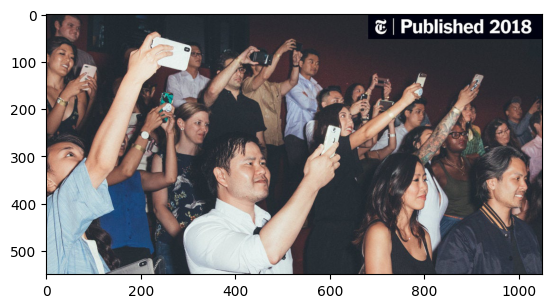

In [167]:
sample = train_val_set[random.randint(0, len(train_val_set))]
masked_sample = randomMask(sample["headline"])
sample["headline"], masked_sample

PADDING = "[ pad ]"
caption = captioner(sample["image"], max_new_tokens=25)
print(masked_sample)
unmasked = unmasker(masked_sample)
prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
section_prompted_unmasked = unmasker(sample["section"] + PADDING + 
                                     caption[0]['generated_text'] + PADDING + masked_sample)

plt.imshow(sample["image"])
print("original headline: " + sample["headline"], "section: " + sample["section"], sep="\n")
print("caption: " + caption[0]['generated_text'], "masked_sample: " + masked_sample, 
      "unmasked: " + unmasked[0]['sequence'], 
      "prompted_unmasked: " + prompted_unmasked[0]['sequence'].split(PADDING)[1],
      "section_prompted_unmasked: " + section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
        sep="\n")

In [183]:
# What percentage improves with adding section as a prompt as well?

train_val_subset = Subset(train_val_set, range(100))
rouge1_fmeasure_prompted = []
rouge1_fmeasure_unprompted = []
rouge1_fmeasure_section_prompted = []
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    
    masked_sample = randomMask(data["headline"])
    
    unmasked = unmasker(masked_sample)
    prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
    section_prompted_unmasked = unmasker(data["section"] + PADDING +
                                            caption[0]['generated_text'] + PADDING + masked_sample)
    rouge1_fmeasure_prompted.append(rouge(prompted_unmasked[0]['sequence'].split(PADDING)[1], 
                                          data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_unprompted.append(rouge(unmasked[0]['sequence'],
                                            data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_section_prompted.append(rouge(section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                                            data["headline"])['rouge1_fmeasure'])

 60%|██████    | 60/100 [02:58<01:49,  2.74s/it]

In [ ]:
rouge1_fmeasure_prompted = np.array(rouge1_fmeasure_prompted)
rouge1_fmeasure_unprompted = np.array(rouge1_fmeasure_unprompted)
rouge1_fmeasure_section_prompted = np.array(rouge1_fmeasure_section_prompted)
print(np.mean(rouge1_fmeasure_prompted), np.std(rouge1_fmeasure_prompted), "\n", 
      np.mean(rouge1_fmeasure_unprompted), np.std(rouge1_fmeasure_unprompted), "\n", 
      np.mean(rouge1_fmeasure_section_prompted), np.std(rouge1_fmeasure_section_prompted))
print(np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_prompted < rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_section_prompted > rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_section_prompted < rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_section_prompted))

0.917615 0.060378004 
 0.91040933 0.0630022 
 0.9105728 0.059519332
0.12 0.04 0.05 0.06 0.09


Observations:
- Adding section additionaly as the prompt does not improve the performance of the model.

Maybe can add a description to section

In [180]:
# What percentage improves with adding section as a prompt as well?

train_val_subset = Subset(train_val_set, range(100))
rouge1_fmeasure_prompted = []
rouge1_fmeasure_unprompted = []
rouge1_fmeasure_section_prompted = []
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    
    masked_sample = randomMask(data["headline"])
    
    unmasked = unmasker(masked_sample)
    prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
    section_prompted_unmasked = unmasker("The context for the caption is {0}.".format(data["section"]) + PADDING +
                                            caption[0]['generated_text'] + PADDING + masked_sample)
    rouge1_fmeasure_prompted.append(rouge(prompted_unmasked[0]['sequence'].split(PADDING)[1], 
                                          data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_unprompted.append(rouge(unmasked[0]['sequence'],
                                            data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_section_prompted.append(rouge(section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                                            data["headline"])['rouge1_fmeasure'])

100%|██████████| 100/100 [05:37<00:00,  3.38s/it]


In [182]:
rouge1_fmeasure_prompted = np.array(rouge1_fmeasure_prompted)
rouge1_fmeasure_unprompted = np.array(rouge1_fmeasure_unprompted)
rouge1_fmeasure_section_prompted = np.array(rouge1_fmeasure_section_prompted)
print(np.mean(rouge1_fmeasure_prompted), np.std(rouge1_fmeasure_prompted), "\n", 
      np.mean(rouge1_fmeasure_unprompted), np.std(rouge1_fmeasure_unprompted), "\n", 
      np.mean(rouge1_fmeasure_section_prompted), np.std(rouge1_fmeasure_section_prompted))
print(np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_prompted < rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_section_prompted > rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_section_prompted < rouge1_fmeasure_unprompted),
      np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_section_prompted),
      np.mean(rouge1_fmeasure_prompted < rouge1_fmeasure_section_prompted))

0.9108278 0.060810447 
 0.9116805 0.060545288 
 0.9144969 0.06289086
0.07 0.09 0.09 0.07 0.03 0.07


Observations:
- Adding descriptive section as a prompt shows more improvement over unprompted captions 